# Stable Diffusion v2.1 and LoRA/DreamBooth Fine-Tuning

This notebook demonstrates how to load the Stable Diffusion v2.1 model, sample from it, perform LoRA fine-tuning, and save/load the fine-tuned model.

In [ ]:
!pip install diffusers transformers accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Load Stable Diffusion v2.1

In [1]:
from diffusers import StableDiffusionPipeline
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
).to("cuda")


pipe.safety_checker = lambda images, clip_input: (images, [False] * len(images))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Sample an Image

In [3]:
# Sample from the model
prompt = "A scenic landscape with mountains"
image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

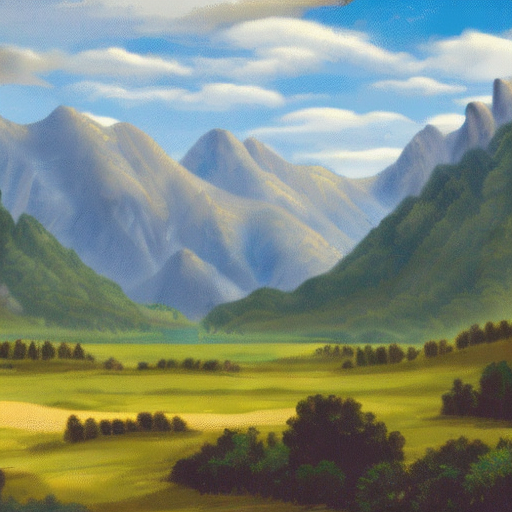

In [4]:
from IPython.display import display

display(image)

  0%|          | 0/50 [00:00<?, ?it/s]

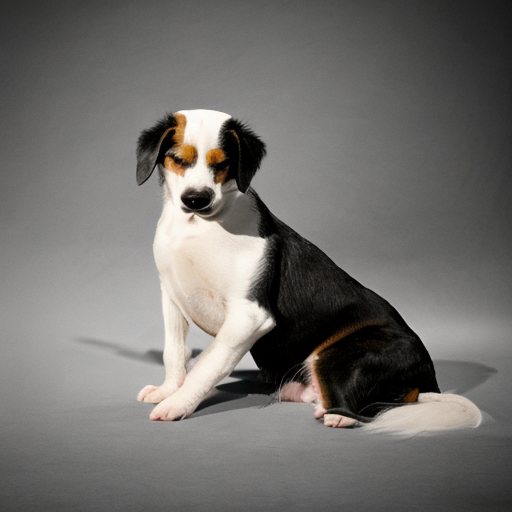

In [5]:
prompt = "A photo of a dog"
image = pipe(prompt).images[0]


display(image)

# LoRA Fine-Tuning Setup
LoRA enables lightweight fine-tuning of Stable Diffusion. We'll use `peft` library to implement it.

In [6]:
import random
from peft import LoraConfig, get_peft_model                        # PEFT LoRA
from torchvision import datasets, transforms
from torch.utils.data import Subset
from tqdm.auto import tqdm

device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
).to(device)

# Freeze all original weights
for comp in [pipe.unet, pipe.text_encoder, pipe.vae]:
    comp.requires_grad_(False)

# Insert LoRA adapters into the UNet
lora_cfg = LoraConfig(
    r               = 4,
    lora_alpha      = 4,
    lora_dropout    = 0.1,
    bias            = "none",
    target_modules  = ["to_q", "to_k", "to_v", "to_out.0"],        # linear proj’s
    init_lora_weights = "gaussian",
)
pipe.unet = get_peft_model(pipe.unet, lora_cfg)
pipe.unet.print_trainable_parameters()                             # sanity‑check

# Prepare a tiny CIFAR‑10 subset
label2prompt = {
    0: "an airplane", 1: "a car", 2: "a bird", 3: "a cat", 4: "a deer",
    5: "a dog", 6: "a frog", 7: "a horse", 8: "a ship", 9: "a truck",
}

tx = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

cifar = datasets.CIFAR10("./data", train=True, download=True, transform=tx)
subset     = Subset(cifar, random.sample(range(len(cifar)), 2_048))
BATCH_SIZE = 4

def collate(batch):
    imgs, labels = zip(*batch)
    prompts = [f"A photo of {label2prompt[l]}" for l in labels]
    return {"pixel_values": torch.stack(imgs), "prompts": prompts}

loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=4, collate_fn=collate, pin_memory=True)

# LoRA fine‑tuning loop
pipe.unet.train()
opt = torch.optim.Adam(pipe.unet.parameters(), lr=1e-4)
pipe.scheduler.set_timesteps(1000)

for epoch in range(1):
    for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
        imgs  = batch["pixel_values"].to(device)
        ids   = pipe.tokenizer(batch["prompts"],
                               padding="max_length",
                               truncation=True,
                               max_length=pipe.tokenizer.model_max_length,
                               return_tensors="pt").input_ids.to(device)

        with torch.no_grad():
            latents = pipe.vae.encode(imgs).latent_dist.sample() * 0.18215

        noise      = torch.randn_like(latents)
        timesteps  = torch.randint(0, pipe.scheduler.num_train_timesteps,
                                   (latents.size(0),), device=device).long()
        noisy_lat  = pipe.scheduler.add_noise(latents, noise, timesteps)
        enc_states = pipe.text_encoder(ids)[0]

        pred       = pipe.unet(noisy_lat, timesteps, enc_states).sample
        loss       = torch.nn.functional.mse_loss(pred, noise)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

trainable params: 829,952 || all params: 866,740,676 || trainable%: 0.0958


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1:   0%|          | 0/512 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


### Save the model

In [8]:
from pathlib import Path

OUTPUT_DIR = Path("./sd21_lora_cifar10")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save just the LoRA layers from the UNet; this is ~2–3 MB instead of many GB
pipe.unet.save_pretrained(f"{OUTPUT_DIR}/lora_unet")

# (Optional) also snapshot the full pipeline with LoRA attached – heavy!
# pipe.save_pretrained(OUTPUT_DIR, safe_serialization=True)

# Load Fine-Tuned Model Weights and Sample

In [9]:
device = "cuda"

# Load the base SD‑2.1 model
pipe_ft = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
).to(device)

# Re‑create the same LoRA parts
lora_cfg = LoraConfig(
    r=4,
    lora_alpha=4,
    lora_dropout=0.1,
    bias="none",
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
)
pipe_ft.unet = get_peft_model(pipe_ft.unet, lora_cfg)

# Load the saved adapter weights and activate them
pipe_ft.unet.load_adapter(f"{OUTPUT_DIR}/lora_unet", adapter_name="default", is_trainable=False)
pipe_ft.unet.set_adapter("default")

pipe_ft.unet.eval()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Linear(in_features=320, out_features=320, bias=True)
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_fea

/tmp/ipython-input-10-3007161961.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():                 # mixed precision is okay for sampling


  0%|          | 0/30 [00:00<?, ?it/s]

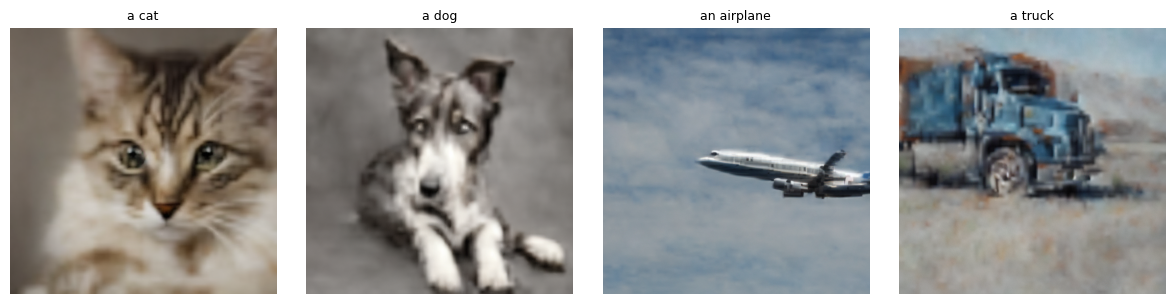

In [10]:
import matplotlib.pyplot as plt

sample_prompts = [
    "A photo of a cat",      # CIFAR‑10 label 3
    "A photo of a dog",      # label 5
    "A photo of an airplane",# label 0
    "A photo of a truck",    # label 9
]

# Generate four images
pipe_ft.scheduler.set_timesteps(30)
with torch.cuda.amp.autocast():
    out = pipe_ft(prompt=sample_prompts,
                  num_inference_steps=30,
                  guidance_scale=7.5)

images = out.images

fig, axes = plt.subplots(1, len(images), figsize=(len(images)*3, 3))
for ax, img, title in zip(axes, images, sample_prompts):
    ax.imshow(img)
    ax.set_title(title.replace("A photo of ", ""), fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()

# DreamBooth Finetuning
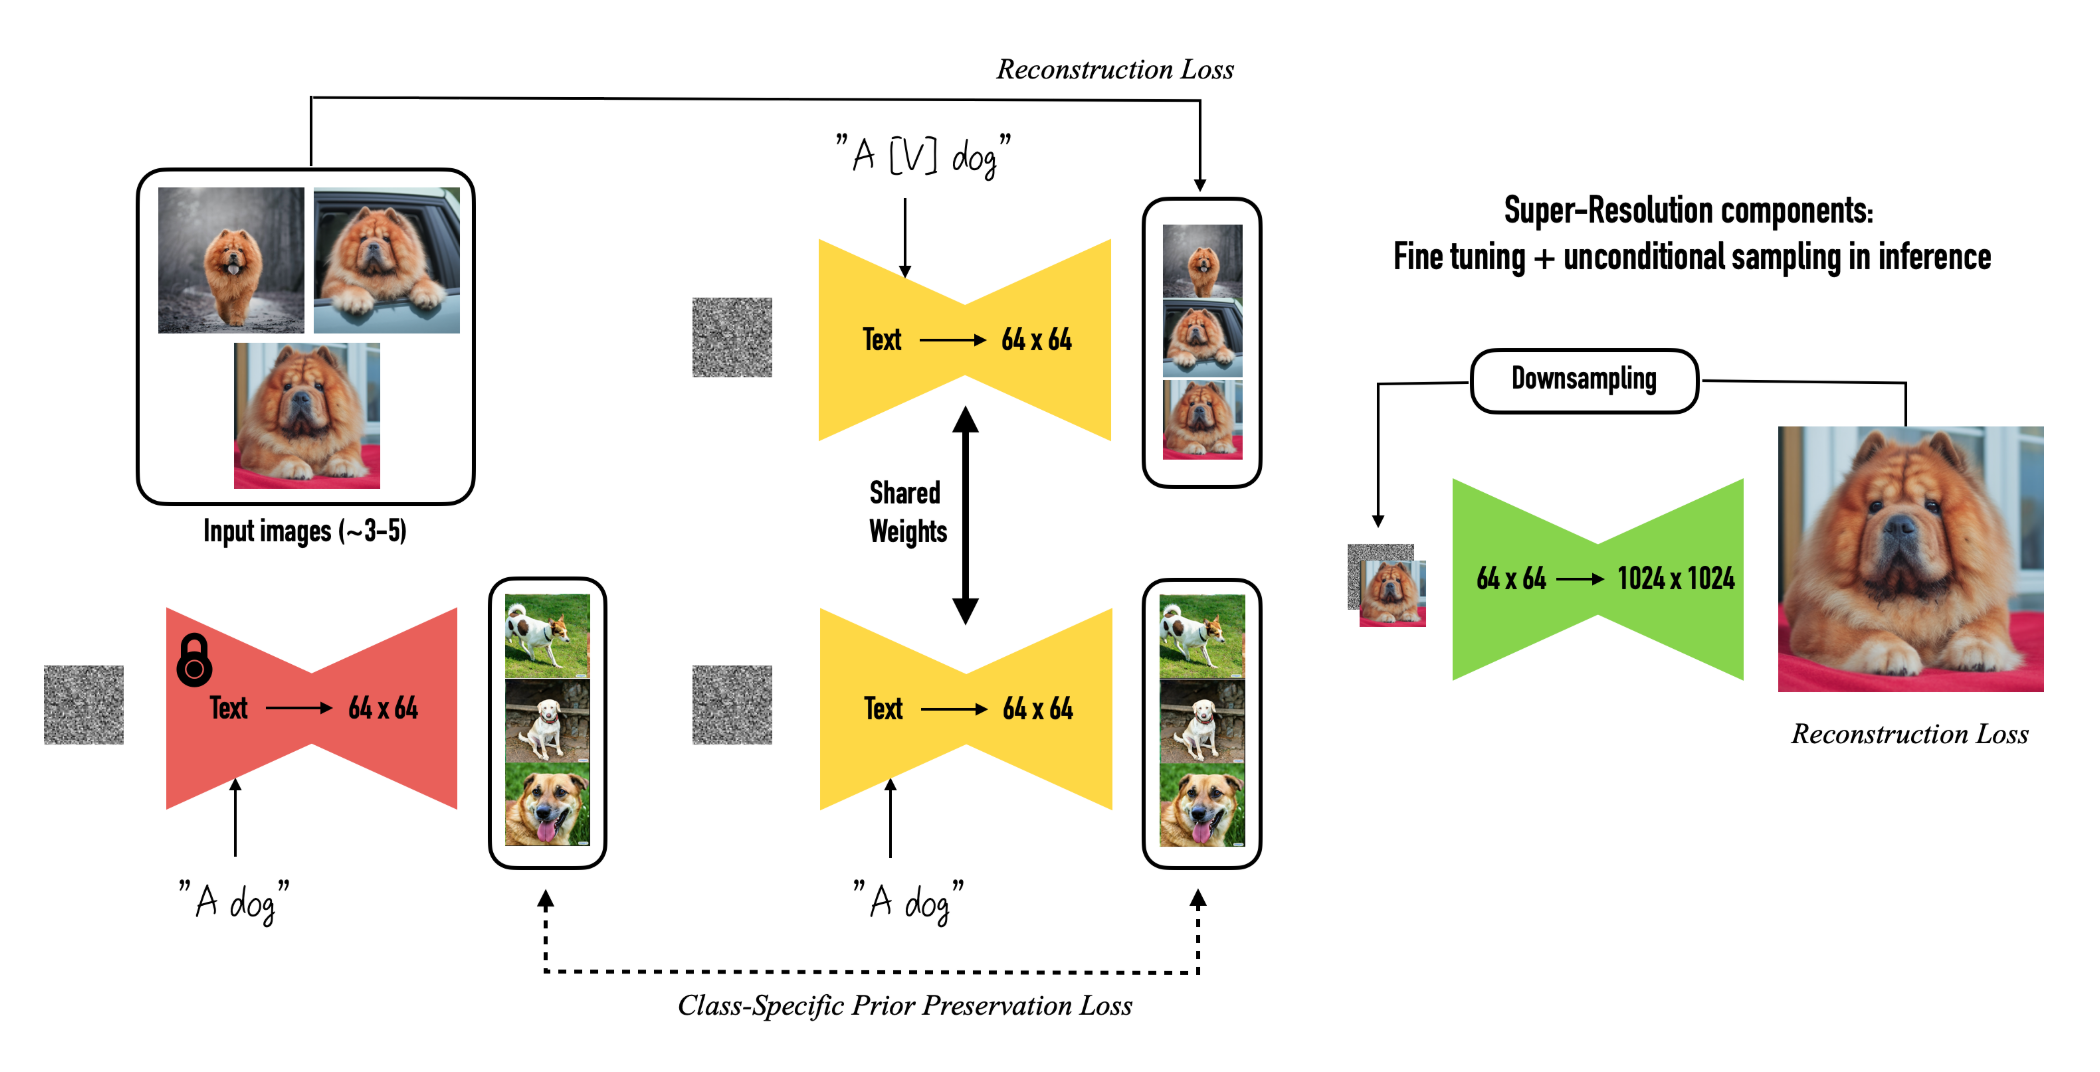





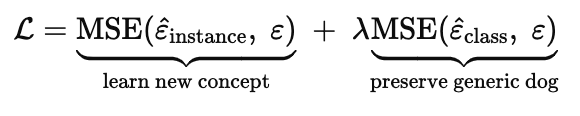

In [1]:
import torch, random
from pathlib import Path
from diffusers import StableDiffusionPipeline
from peft import LoraConfig, get_peft_model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
).to(device)

# Freeze everything; LoRA will adapt UNet only
for comp in [pipe.unet, pipe.text_encoder, pipe.vae]:
    comp.requires_grad_(False)

lora_cfg = LoraConfig(
    r=4, lora_alpha=4, lora_dropout=0.1, bias="none",
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    init_lora_weights="gaussian",
)
pipe.unet = get_peft_model(pipe.unet, lora_cfg)
pipe.unet.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

trainable params: 829,952 || all params: 866,740,676 || trainable%: 0.0958


In [3]:
import pathlib, PIL
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch, random

# custom instance photos
INSTANCE_DIR = pathlib.Path("./cat_photos")
instance_files = sorted(INSTANCE_DIR.glob("*.jpg"))


# generic class photos (cats)
pets = load_dataset("timm/oxford-iiit-pet", split="train")  # ≈ 37 cat/dog breeds
class_imgs = [ex["image"] for ex in pets if ex["label"] == 0]  # label 0 = cat
random.shuffle(class_imgs)
class_imgs = class_imgs[:200]                                 # keep ~200

tx = transforms.Compose([
    transforms.Resize(512, antialias=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

class DreamBoothSet(Dataset):
    def __init__(self, img_sources, prompt):
        self.img_sources = img_sources
        self.prompt = prompt

    def __len__(self):  return len(self.img_sources)

    def __getitem__(self, idx):
        img_src = self.img_sources[idx]
        img = PIL.Image.open(img_src).convert("RGB") if isinstance(img_src, pathlib.Path) else img_src
        return {
            "pixel_values": tx(img),
            "input_ids": pipe.tokenizer(
                self.prompt,
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids.squeeze(0)
        }

INSTANCE_TOKEN, CLASS_TOKEN = "sks", "cat"
instance_prompt = f"a photo of {INSTANCE_TOKEN} {CLASS_TOKEN}"
class_prompt    = f"a photo of a {CLASS_TOKEN}"

instance_set = DreamBoothSet(instance_files, instance_prompt)
class_set    = DreamBoothSet(class_imgs,   class_prompt)

loader_inst  = DataLoader(instance_set, batch_size=1, shuffle=True, num_workers=2)
loader_class = DataLoader(class_set,    batch_size=4, shuffle=True, num_workers=2)

print(f"Instance images : {len(instance_set)}  |  Class images : {len(class_set)}")


Instance images : 5  |  Class images : 100


In [4]:
pipe.unet.train()
opt = torch.optim.Adam(pipe.unet.parameters(), lr=5e-5)
pipe.scheduler.set_timesteps(1000)

PRIOR_WEIGHT = 1.0     # λ in DreamBooth loss

for epoch in range(1):
    pbar = tqdm(zip(loader_inst, loader_class),
                total=min(len(loader_inst), len(loader_class)),
                desc="DreamBooth epoch")
    for batch_inst, batch_cls in pbar:
        # merge instance + class

        batch = {k: torch.cat([batch_inst[k], batch_cls[k]], dim=0) for k in batch_inst}
        imgs  = batch["pixel_values"].to(device)
        ids   = batch["input_ids"].to(device)

        with torch.no_grad():
            latents = pipe.vae.encode(imgs).latent_dist.sample() * 0.18215

        noise      = torch.randn_like(latents)
        t          = torch.randint(0, pipe.scheduler.num_train_timesteps,
                                   (latents.size(0),), device=device).long()
        noisy_lat  = pipe.scheduler.add_noise(latents, noise, t)
        enc_states = pipe.text_encoder(ids)[0]

        pred       = pipe.unet(noisy_lat, t, enc_states).sample

        inst_pred, class_pred = pred.chunk(2)
        inst_noise, class_noise = noise.chunk(2)

        loss_inst  = torch.nn.functional.mse_loss(inst_pred, inst_noise)
        loss_prior = torch.nn.functional.mse_loss(class_pred, class_noise)
        loss       = loss_inst + PRIOR_WEIGHT * loss_prior

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

DreamBooth epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [5]:
OUTPUT_DIR = Path("./sd21_lora_dreambooth")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
pipe.unet.save_pretrained(OUTPUT_DIR / "lora_unet")

In [6]:
pipe_ft = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
).to(device)

pipe_ft.unet = get_peft_model(pipe_ft.unet, lora_cfg)
pipe_ft.unet.load_adapter(OUTPUT_DIR / "lora_unet",
                          adapter_name="default", is_trainable=False)
pipe_ft.unet.set_adapter("default")
pipe_ft.unet.eval()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Linear(in_features=320, out_features=320, bias=True)
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_fea

/tmp/ipython-input-16-2298202437.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/30 [00:00<?, ?it/s]

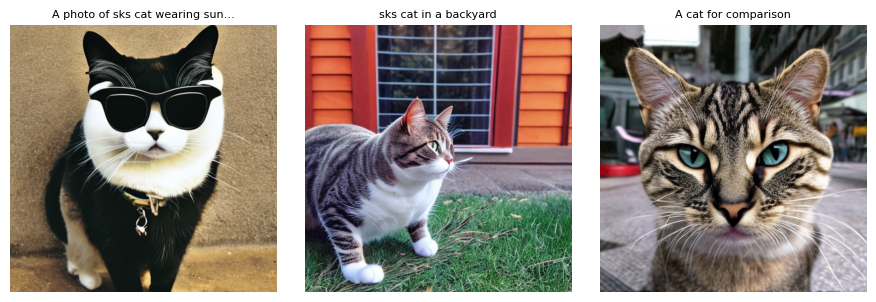

In [16]:
import matplotlib.pyplot as plt

prompts = [
    f"A photo of {INSTANCE_TOKEN} {CLASS_TOKEN} wearing sunglasses",
    f"{INSTANCE_TOKEN} {CLASS_TOKEN} in a backyard",
    f"A {CLASS_TOKEN} for comparison",                # no instance token
]

pipe_ft.scheduler.set_timesteps(30)
with torch.cuda.amp.autocast():
    out = pipe_ft(prompt=prompts,
                  num_inference_steps=30,
                  guidance_scale=7.5)

fig, axes = plt.subplots(1, len(prompts), figsize=(len(prompts)*3,3))
for ax, img, p in zip(axes, out.images, prompts):
    ax.imshow(img)
    ax.set_title(p[:30]+"…" if len(p)>30 else p, fontsize=8)
    ax.axis("off")
plt.tight_layout(); plt.show()